In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt 

import module.content as content
import module.features as features
from joblib import load
import argparse
import time

In [2]:
model_4D = 'mini_kmeans_4D_3_3x3'
model_3D = 'mini_kmeans_3D_3_3x3' 
size = 3 
timestamp = 5
begin_slice = 600
end_slice = 604
pore_4D = 2
pore_3D = 0

In [3]:
# Here we set the paramater
mask_centre = (700, 810)
radius = 550

# get the path for target slice
current_path = os.getcwd()
print(current_path)
all_timestamp = content.get_folder(current_path)
sub_path = os.path.join(current_path, all_timestamp[timestamp])
sub_all_tif = content.get_allslice(sub_path)

sub_path_previous = os.path.join(current_path, all_timestamp[timestamp-1])
sub_path_next = os.path.join(current_path, all_timestamp[timestamp+1])


# load the model from 'model' folder
model_4D_path = os.path.join(current_path, 'model', model_4D+'.model')
model_3D_path = os.path.join(current_path, 'model', model_3D+'.model')
model_4D_type = load(model_4D_path)
model_3D_type = load(model_3D_path)

centre_4D = model_4D_type.cluster_centers_
centre_3D = model_3D_type.cluster_centers_

num_centre_3D = centre_3D.shape[0]
num_centre_4D = centre_4D.shape[0]


/Users/gavin/MSc-Project


In [4]:
image_batch, height, width = features.get_3D_structure(sub_path, begin_slice, end_slice)
image_batch_previous, _, _ = features.get_3D_structure(sub_path_previous, begin_slice, end_slice)
image_batch_next, _, _ = features.get_3D_structure(sub_path_next, begin_slice, end_slice)

Creating image batch...
Finished!
Creating image batch...
Finished!
Creating image batch...
Finished!


In [11]:
conv_stride = [1,1,1,1,1]
x_3D = tf.compat.v1.placeholder(tf.float32, shape=(1, end_slice-begin_slice+1, height, width, 1))

0
601
1
602
2
603


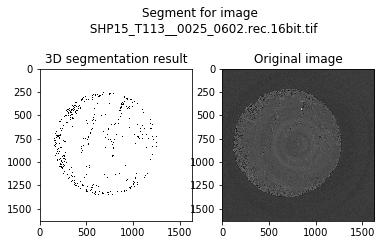

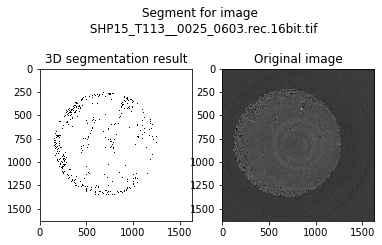

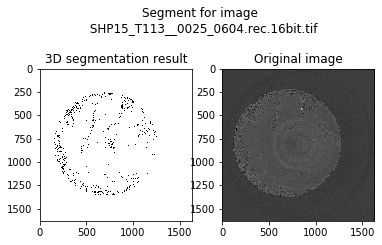

In [62]:
kernel_3D_list = [tf.reshape(tf.constant(i, tf.float32), (3,3,3,1,1)) for i in centre_3D]
constant_3D_list = [np.sum(i**2) for i in centre_3D]


# create graph for tensorflow
x_3D = tf.compat.v1.placeholder(tf.float32, shape=(1, end_slice-begin_slice+1, height, width, 1))
layer_list_3D = [tf.nn.conv3d(x_3D, filter=i, strides = conv_stride, padding='SAME') for i in kernel_3D_list]

# run the graph
with tf.compat.v1.Session() as sess:
    result = [sess.run(i, feed_dict={x_3D:image_batch}) for i in layer_list_3D]

# reshape and calculate the distance
result_reshape = [i.reshape(end_slice-begin_slice+1, height, width) for i in result]
distance_list = [constant_3D_list[i]-2*result_reshape[i] for i in range(num_centre_3D)]

# we only care the mask, so create mask here
mask = np.zeros((height, width), np.uint8)
cv2.circle(mask, mask_centre, radius, 1, thickness=-1)

compare_3D = [distance_list[pore_3D] < distance_list[j] for j in range(num_centre_3D) if j != pore_3D]

segment_3D = mask
for i in compare_3D:
    segment_3D = segment_3D * i
# inverse color for plotting
segment_inv_3D = cv2.bitwise_not(segment_3D)


# plot the picture
for index, i in enumerate(range(begin_slice+1, end_slice)):
    print(index)
    print(i)
    fig = plt.figure()
    fig.suptitle('Segment for image \n {string}'.format(string=os.path.basename(sub_all_tif[i])))
    ax = plt.subplot(121)
    ax.imshow(segment_inv_3D[index+1], 'gray')
    ax.set_title('3D segmentation result')

    ax = plt.subplot(122)
    img = cv2.imread(sub_all_tif[i], -1)
    ax.imshow(img, 'gray')
    ax.set_title('Original image')

plt.show()

In [8]:
kernel_4D_list_1 = [tf.reshape(tf.constant(i[:27], tf.float32), (3,3,3,1,1)) for i in centre_4D]
kernel_4D_list_2 = [tf.reshape(tf.constant(i[27:54], tf.float32), (3,3,3,1,1)) for i in centre_4D]
kernel_4D_list_3 = [tf.reshape(tf.constant(i[54:81], tf.float32), (3,3,3,1,1)) for i in centre_4D]

In [40]:
constant_4D_list = [np.sum(i**2) for i in centre_4D]

In [41]:
constant_4D_list

[54679805771.32409, 67538120964.61733, 48393545597.651344]

In [14]:
layer_list_4D_1 = [tf.nn.conv3d(x_3D, filter=i, strides = conv_stride, padding='SAME') for i in kernel_4D_list_1]
layer_list_4D_2 = [tf.nn.conv3d(x_3D, filter=i, strides = conv_stride, padding='SAME') for i in kernel_4D_list_2]
layer_list_4D_3 = [tf.nn.conv3d(x_3D, filter=i, strides = conv_stride, padding='SAME') for i in kernel_4D_list_3]

In [15]:
with tf.compat.v1.Session() as sess:
	result_4D_1 = [sess.run(i, feed_dict={x_3D:image_batch}) for i in layer_list_4D_1]
	result_4D_2 = [sess.run(i, feed_dict={x_3D:image_batch_previous}) for i in layer_list_4D_2]
	result_4D_3 = [sess.run(i, feed_dict={x_3D:image_batch_next}) for i in layer_list_4D_3]

In [16]:
result_4D_1_reshape = [i.reshape(end_slice-begin_slice+1, height, width) for i in result_4D_1]
result_4D_2_reshape = [i.reshape(end_slice-begin_slice+1, height, width) for i in result_4D_2]
result_4D_3_reshape = [i.reshape(end_slice-begin_slice+1, height, width) for i in result_4D_3]

In [42]:
distance_list_4D = [constant_4D_list[i]-2*result_4D_1_reshape[i]-2*result_4D_2_reshape[i]-2*result_4D_3_reshape[i] for i in range(num_centre_4D)]

In [25]:
distance_list_4D_1 = [constant_4D_list_1[i]-2*result_4D_1_reshape[i] for i in range(num_centre_4D)]
distance_list_4D_2 = [constant_4D_list_2[i]-2*result_4D_2_reshape[i] for i in range(num_centre_4D)]
distance_list_4D_3 = [constant_4D_list_3[i]-2*result_4D_3_reshape[i] for i in range(num_centre_4D)]

In [43]:
distance_list_4D[0].shape

(5, 1632, 1632)

In [44]:
mask = np.zeros((height, width), np.uint8)
cv2.circle(mask, mask_centre, radius, 1, thickness=-1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [52]:
pore_4D = 0

In [53]:
compare_4D = [distance_list_4D_all[pore_4D] < distance_list_4D_all[j] for j in range(num_centre_4D) if j != pore_4D]

In [61]:
segment_4D = mask
for i in compare_4D:
	segment_4D = segment_4D * i

In [59]:
segment_inv_4D = cv2.bitwise_not(segment_4D)

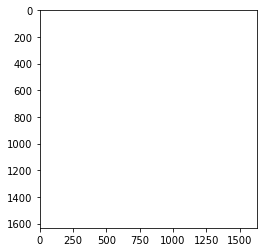

In [58]:
plt.imshow(segment_inv_4D[1],'gray')
plt.show()